## Context

Dug into Instacart's open data as part of the Kaggle challenge "Instacart Market Basket Analysis." The premise is to build a model that can predict which products an Instacart consumer will purchase again.

The goal wasn't to enter the competition, but just to practice exploring another company's data and build out a simple model. Spent a few hours after work on this, but didn't have time to devote any real digging. Maybe when I'm in between jobs some day.

In [268]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ggplot import *
%matplotlib inline

## Import Data

* 3 to 99 prior orders are stored in the prior order set
* user's last order (4th - 100th) is in train and test

In [3]:
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

In [4]:
print "unique aisles: " + str(len(aisles))
print "unique departments: " + str(len(departments))
print "unique orders: " + "{:,}".format(len(orders))
print "unique products: " + "{:,}".format(len(products))
print "-----------"
print "order product pairs in order-product-prior: " + "{:,}".format(len(order_products_prior))
print "unique order ids in order-product-prior: " + "{:,}".format(len(order_products_prior.order_id.unique()))
print "-----------"
print "order product training pairs in order-product-train: " + "{:,}".format(len(order_products_train))
print "unique order ids in order-product-train: " + "{:,}".format(len(order_products_train.order_id.unique()))

unique aisles: 134
unique departments: 21
unique orders: 3,421,083
unique products: 49,688
-----------
order product pairs in order-product-prior: 32,434,489
unique order ids in order-product-prior: 3,214,874
-----------
order product training pairs in order-product-train: 1,384,617
unique order ids in order-product-train: 131,209


In [5]:
# doesn't look like there are any duplicate order id, product id pairs
r = order_products_train.groupby(['order_id', 'product_id']).size()
r[r > 1]

Series([], dtype: int64)

In [6]:
# one row per order_id in orders
print len(orders)
print len(orders.order_id.unique())

3421083
3421083


In [336]:
order_products_train.head(1)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1


In [337]:
orders.head(1)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN


In [338]:
products.head(1)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19


In [10]:
# TODO: this is wrong, i should be using the prior dataset, not the train one (applies to all downstream cells)
# df: using only the train dataset
# order id, product id, order number, add to cart order,
# reordered, order dow, order hour of day, days since prior order, 
# aisle, department, product name
df = pd.merge(pd.merge(pd.merge(pd.merge(orders, order_products_train, on='order_id', how='inner'),
                                products, on='product_id', how='left'),
                       aisles, on='aisle_id', how='left'),
              departments, on='department_id', how='left')

In [12]:
print len(order_products_train)
print len(df)

1384617
1384617


In [339]:
df.head(1)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,1187899,1,train,11,4,8,14.0,196,1,1,Soda,77,7,soft drinks,beverages


In [64]:
# check the data types of everything i'm working with
df.dtypes

order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
product_id                  int64
add_to_cart_order           int64
reordered                   int64
product_name               object
aisle_id                    int64
department_id               int64
aisle                      object
department                 object
dtype: object

In [76]:
# assumption: each product can only be in one aisle and one department? yes
a = df.groupby('product_id').aisle_id.nunique()
a[a > 1]
b = df.groupby('aisle_id').department_id.nunique()
b[b > 1]

Series([], Name: department_id, dtype: int64)

## Exploration

Notes from exploring this stuff
* Product re-ordering behavior:
    * Milk, eggs, fruit, seltzer among high volume/high reorder group; spices, baking supplies among the lowest
    * Banana specifically is one of the highest volume/highest reorder product
    * 93.4% of orders in the training dataset are reorders
    * Days since previous order spikes at around 7 days and again at 30 days (probably just because of how the dataset was compiled/capped)
* Order behavior:
    * Orders highest on Sundays and Mondays; late mornings and early afternoons
    * Not much variation in order hour of day across item departments
    * Users (in this dataset) have at least 4 orders, uptick at 100 orders (probably just because of how the dataset was compiled)
    * Median products per order in the training set is 9, average 10


In [ ]:
t = df.groupby(['aisle', 'department']).agg({'product_id': 'count', 'reordered': 'sum'}).reset_index()
t.columns = ['aisle', 'department', 'purchases', 'reorders']
t['log_purchases'] = np.log(t.purchases)
t['ratio_of_purchases_that_are_reorders'] = t['reorders']/t['purchases']

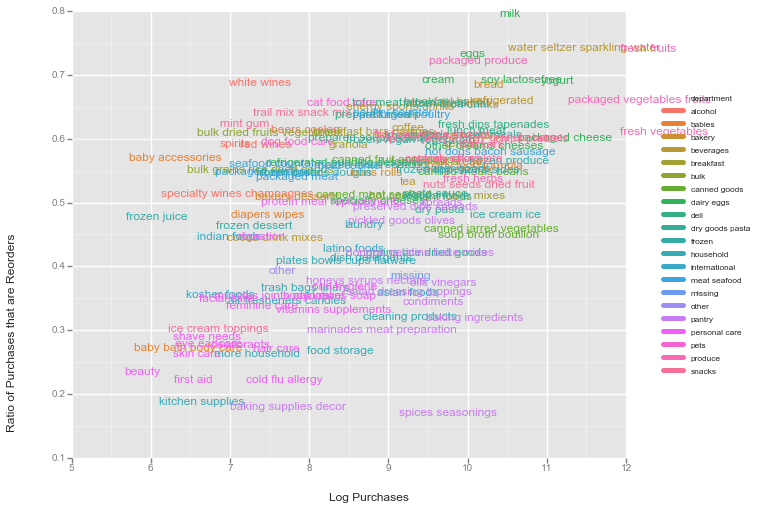

<ggplot: (283805149)>

In [59]:
ggplot(t, aes(x='log_purchases', y='ratio_of_purchases_that_are_reorders', color='department', label='aisle')) +\
    xlab("Log Purchases") + ylab("Ratio of Purchases that are Reorders") +\
    geom_text()

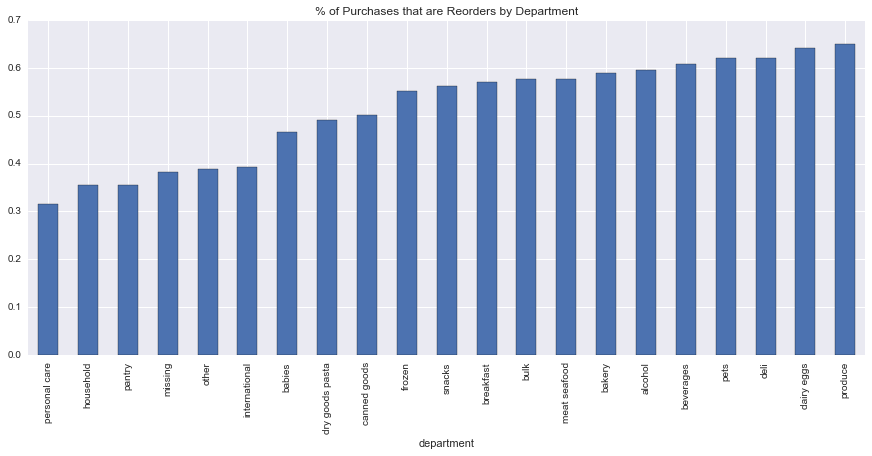

In [331]:
t.groupby('department').ratio_of_purchases_that_are_reorders.mean().sort_values().plot(
    kind='bar', title='% of Purchases that are Reorders by Department', figsize=(15,6))

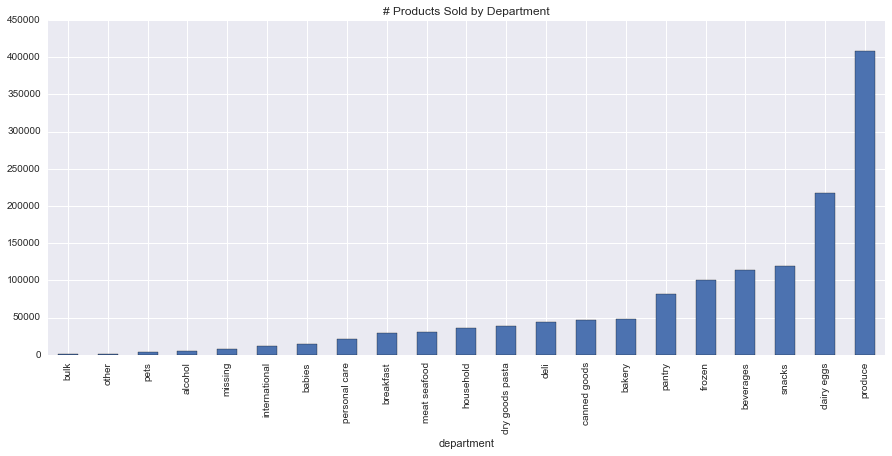

In [330]:
ax = t.groupby('department').purchases.sum().sort_values().plot(kind='bar', figsize=(15,6))
ax.set_title('# Products Sold by Department')

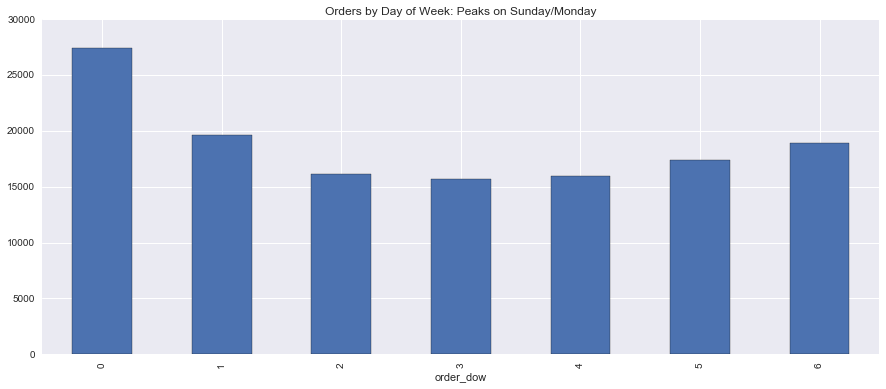

In [332]:
df.groupby('order_dow')['order_id'].apply(lambda x: len(x.unique())).plot(kind='bar',
    title='Orders by Day of Week: Peaks on Sunday/Monday', figsize=(15,6))

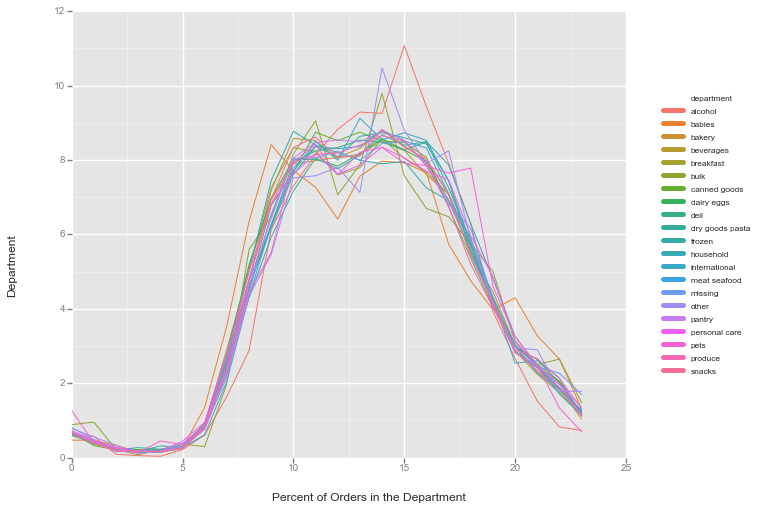

<ggplot: (299848669)>

In [117]:
h = df.groupby(['department', 'order_hour_of_day']).order_id.count()
h.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index()
ggplot(h.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index(),
       aes(x='order_hour_of_day', y='order_id', color='department')) + geom_line() + \
       xlab("Percent of Orders in the Department") + ylab("Department")

In [312]:
# Products with the highest reorder rate (with at least 100 orders)
p = df.groupby('product_name').agg({'reordered': 'sum', 'product_id': 'count'})
p['reordered_rate'] = p['reordered']/p['product_id']
p[(p.product_id > 100)].sort_values(by='reordered_rate', ascending=False).head(5)

,product_id,reordered,reordered_rate
product_name,,,
Organic Low Fat Milk,368,336,0.913043
Banana,18726,16557,0.884172
Petit Suisse Fruit,120,106,0.883333
Organic Lowfat 1% Milk,483,426,0.881988
Organic Lactose Free 1% Lowfat Milk,269,237,0.881041


In [313]:
# Products with the highest reorder rate (with at least 100 orders)
p[(p.product_id > 100)].sort_values(by='reordered_rate', ascending=False).tail(5)

,product_id,reordered,reordered_rate
product_name,,,
Ground Cumin,164,15,0.091463
Onion Powder,138,12,0.086957
Bay Leaves,136,10,0.073529
Paprika,138,10,0.072464
Organic Turmeric,113,8,0.070796


In [309]:
# Aisles with the highest reorder rate (with at least 100 orders)
a = df.groupby('aisle').agg({'reordered': 'sum', 'aisle_id': 'count'})
a['reordered_rate'] = a['reordered']/a['aisle_id']
a[(a.aisle_id > 100)].sort_values(by='reordered_rate', ascending=False).head(5)

,aisle_id,reordered,reordered_rate
aisle,,,
milk,32644,25864,0.792305
water seltzer sparkling water,36617,27011,0.737663
fresh fruits,150473,110782,0.736225
eggs,19875,14488,0.728956
packaged produce,13460,9657,0.717459


In [310]:
# Aisles with the lowest reorder rate (with at least 100 orders)
a[(a.aisle_id > 100)].sort_values(by='reordered_rate', ascending=False).tail(5)

,aisle_id,reordered,reordered_rate
aisle,,,
cold flu allergy,1346,294,0.218425
first aid,539,117,0.217069
kitchen supplies,448,82,0.183036
baking supplies decor,1094,192,0.175503
spices seasonings,9279,1534,0.165320


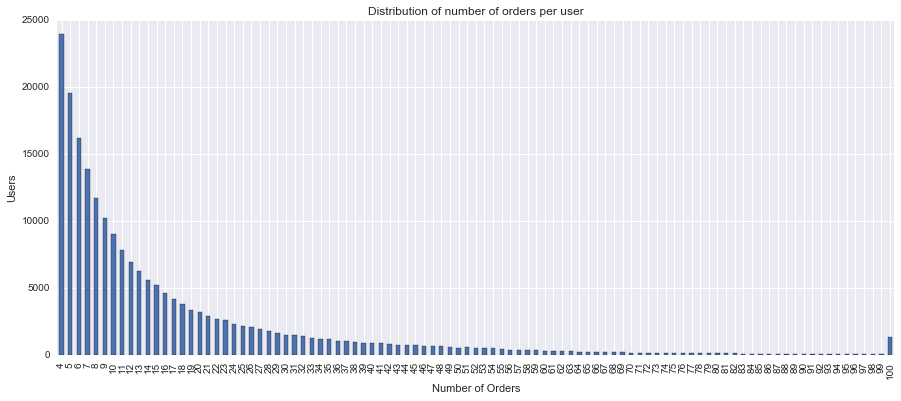

In [293]:
orders_per_user = orders.groupby('user_id').order_number.max().value_counts()
ax = orders_per_user.sort_index().plot(kind='bar', figsize=(15,6))
ax.set_ylabel('Users')
ax.set_xlabel('Number of Orders')
ax.set_title('Distribution of number of orders per user')

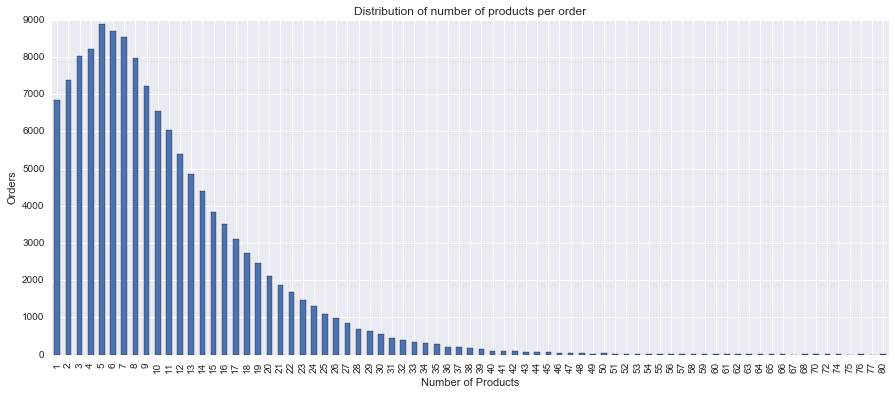

In [292]:
products_per_order = order_products_train.groupby('order_id').add_to_cart_order.max().value_counts()
ax = products_per_order.sort_index().plot(kind='bar', figsize=(15,6))
ax.set_ylabel('Orders')
ax.set_xlabel('Number of Products')
ax.set_title('Distribution of number of products per order')

In [306]:
order_products_train.groupby('order_id').add_to_cart_order.max().describe()

count    131209.000000
mean         10.552759
std           7.932847
min           1.000000
25%           5.000000
50%           9.000000
75%          14.000000
max          80.000000
Name: add_to_cart_order, dtype: float64

In [220]:
orders_with_reorder = pd.DataFrame(list(set(df[df.reordered == 1].order_id)), columns=['order_id'])
orders_with_reorder['reorder_flag'] = 1
o = pd.merge(orders[orders.eval_set == 'train'], orders_with_reorder, on='order_id', how='left')
o.fillna(0, inplace=True)

In [222]:
print "percent of orders that are reorders " + "{:.2f}%".format(float(len(orders_with_reorder))/len(o)*100)

percent of orders that are reorders 93.44%


In [223]:
o.groupby('reorder_flag')[['order_number', 'order_dow', 'days_since_prior_order']].describe().round(2)

order_number  order_dow  days_since_prior_order
reorder_flag                                                       
0.0          count       8602.00    8602.00                 8602.00
             mean           9.32       2.95                   20.52
             std            9.33       1.99                   11.16
             min            4.00       0.00                    0.00
             25%            4.00       1.00                    9.00
             50%            6.00       3.00                   29.00
             75%           10.00       5.00                   30.00
             max          100.00       6.00                   30.00
1.0          count     122607.00  122607.00               122607.00
             mean          17.12       2.76                   16.81
             std           16.94       2.13                   10.60
             min            4.00       0.00                    0.00
             25%            6.00       1.00                    7.00
             50%           11.00       3.00                   15.00
             75%           21.00       5.00                   30.00
             max          100.00       6.00                   30.00

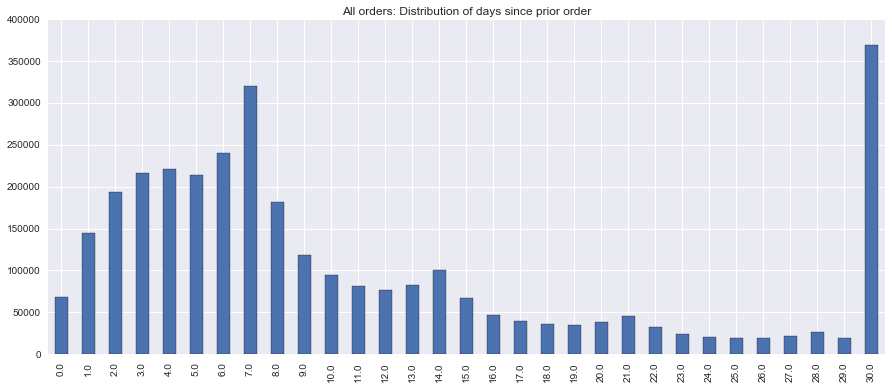

In [303]:
orders.days_since_prior_order.value_counts().sort_index().plot(
    kind='bar', figsize=(15,6), title='All orders: Distribution of days since prior order')

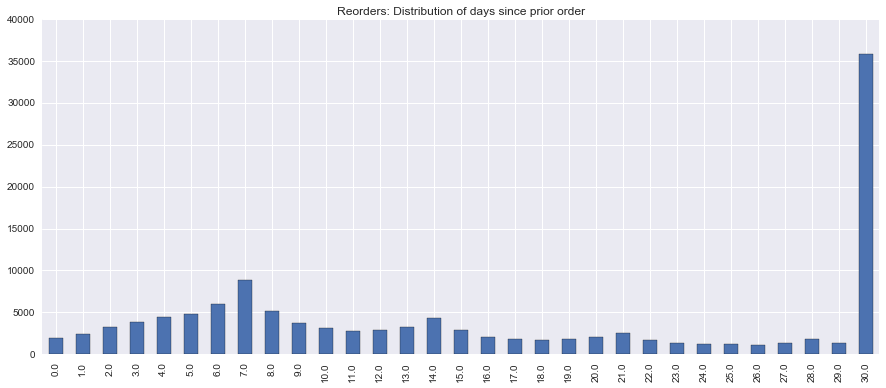

In [302]:
o[o.reorder_flag == 1].days_since_prior_order.value_counts().sort_index().plot(
    kind='bar', figsize=(15,6), title='Reorders: Distribution of days since prior order')

## Feature Engineering

In [379]:
# start with basics: for a given user_id, product_id in the training set
# keep order_number, order_dow, order_hour_of_day, days_since_prior_order, add_to_cart_order, reordered
train_data = df[['user_id', 'product_id', 'order_number', 'order_dow', 'order_hour_of_day',
                 'days_since_prior_order', 'add_to_cart_order', 'reordered']]

In [380]:
# add in the overall average reordered rate for a given product id
# only add it though if volume is past a certain threshold though because an item ordered a few times could be deceiving?
# TODO: use a bayesian prior for reorder rates for products with low volume
p = order_products_prior.groupby('product_id').agg({'reordered': 'sum', 'order_id': 'count'})
p.columns = ['orders', 'reordered']
p['reordered_rate'] = p['reordered']/p['orders']
train_data = pd.merge(train_data, p[p.orders >= 10].reset_index()[['product_id', 'reordered_rate']], on='product_id', how='left')

In [ ]:
# add in a user's number of orders for a given product already

In [341]:
# was in last order
# was in 2nd last order
# was in 3rd last order
# days since product was last ordered
# number of times ordered

,product_id,reordered,reordered_rate
product_name,,,
#2 Coffee Filters,22,8,0.363636


In [ ]:
# NOT FINISHED YET